# Machine Learning Engineer Nanodegree: Forecasting COVID-19 Cases – A `Time Series Forecasting` Model

### Domain Background
On December 31, 2019, the World Health Organization (WHO) was informed of an outbreak of “pneumonia of unknown cause” detected in Wuhan City, Hubei Province, China. Identified as coronavirus disease 2019, it quickly came to be known as COVID-19 and has resulted in an ongoing global pandemic. As of 20 June 2020, more than 8.74 million cases have been reported across 188 countries and territories, resulting in more than 462,000 deaths. More
than 4.31 million people have recovered.[^1]

In response to this ongoing public health emergency, Johns Hopkins University (JHU), a private research university in Maryland, USA, developed an interactive web-based dashboard hosted by their Center for Systems Science and Engineering (CSSE). The dashboard visualizes and tracks reported cases in real-time, illustrating the location and number of confirmed COVID-19 cases, deaths and recoveries for all affected countries. It is used by researchers, public health authorities, news
agencies and the general public. All the data collected and displayed is made freely available in a [GitHub repository](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

### Problem Statement
This project seeks to forecast number of people infected and number of deaths caused by COVID-19 for a time duration of 14-days based on
historical data from JHU. I will be using Amazon SageMaker DeepAR forecasting algorithm, a supervised learning algorithm for forecasting
scalar (one-dimensional) time series using recurrent neural networks (RNN) to produce both point and probabilistic forecasts[^2].
DeepAR is an underutilized approach in this area.[^3] The dataset contains hundreds of related time series, and DeepAR outperforms classical
forecasting methods including but not limited to autoregressive integrated moving average (ARIMA), exponential smoothing (ETS), Time Series
Forecasting with Linear Learner for this type of applications. I will be using [DeepAR](https://github.com/sahussain/ML_SageMaker_Studies/blob/master/Time_Series_Forecasting/Energy_Consumption_Solution.ipynb) and [Time Series Forecasting with Linear Learner](https://github.com/awslabs/amazon-sagemaker-examples/blob/80333fd4632cf6d924d0b91c33bf80da3bdcf926/introduction_to_applying_machine_learning/linear_time_series_forecast/linear_time_series_forecast.ipynb)

-----------
[^1]:[COVID-19 Dashboard](https://systems.jhu.edu/research/public-health/ncov/) by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)". ArcGIS. Johns Hopkins University. Retrieved 20 June 2020.

[^2]:[DeepAR Forecasting Algorithm. Amazon Web Services](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). Retrieved 20 June, 2020 

[^3]:[Time series prediction](https://www.telesens.co/2019/06/08/time-series-prediction/). Telesens. Retrieved 20 June, 2020.

-----------

## Loading in the resources.

In [56]:
#General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import json # import json for formatting data
import os # os for saving
import io
from urllib.request import urlretrieve
import sys
import random
from datetime import datetime

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

# for both DeepAR & Linear Learner
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker.estimator import Estimator

#for Linear Learner
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer

## Initialize Global variables

In [57]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix_DeepAR='deepar'
prefix = 'linear'
df_start_date = '2020-01-22'

container_linear_learner = get_image_uri(boto3.Session().region_name,'linear-learner')
container_DeepAR = get_image_uri(boto3.Session().region_name,'forecasting-deepar')

## Download function

In [3]:
def progress_report_hook(count, block_size, total_size):
    mb = int(count * block_size // 1e6)
    if count % 50 == 0:
        sys.stdout.write("\r{} MB downloaded".format(mb))
        sys.stdout.flush()

def download(DATA_HOST, DATA_PATH, FILE_NAME, OVERRIDE=1, reporthook=progress_report_hook):
    if OVERRIDE:
        print("downloading dataset, can take a few minutes depending on your connection")
        urlretrieve(DATA_HOST + DATA_PATH + FILE_NAME, FILE_NAME, reporthook=progress_report_hook)
    else:
        print("File found skipping download")

## Clean-up functions

In [4]:
#convenience function to delete prediction endpoints after we're done with them form udacity
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

-----------

## Load and Explore the Data

### Downloading data

In [5]:
DATA_HOST = "https://raw.githubusercontent.com"
DATA_PATH = "/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
FILE_NAME = "time_series_covid19_confirmed_US.csv"

In [6]:
download(DATA_HOST, DATA_PATH, FILE_NAME,0)

File found skipping download


### Loading data into pandas

In [7]:
csv_file = 'time_series_covid19_confirmed_US.csv'
covid_df = pd.read_csv(csv_file)

### Examining the Data

In [8]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,183,183,183,185,186,188,192,200,222,222
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,30,30,30,30,30,30,30,30,30,30
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,5536,5690,5811,5890,5951,6003,6111,6195,6463,6525
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,72,72,72,72,72,73,73,73,73,76


In [9]:
#Geting colunm names
list(covid_df.columns)

['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
 '1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5

Looks like we have the metadata form column 0 to 11 and columns 12 to end is for each day

## Datasets and Inputs
The datasets are accessed from files provided by the JHU GitHub
repository [time_series_covid19_confirmed_US.csv](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv)

The file have the same columns:
* UID - UID = 840 (country code3) + 000XX (state FIPS code). Ranging from
8400001 to 84000056.
* iso2- Officially assigned country code identifiers 2 Chr (US, CA, ...)
* iso3 - Officially assigned country code identifiers 3 Chr.(USA, CAN,
...)
* code3- country code USA = 840
* FIPS -Federal Information Processing Standards code that uniquely
identifies counties within the USA.
* admin2 - County name. US only.
* Province_State - The name of the State within the USA.
* Country_Region - The name of the Country (US).
* Combined_Key - Province_State + Country_Region
* Population - Population
* Number of cases are is columns where each column is a day



In [10]:
#filter code3 - country code: USA = 840 as the scope of this project is limited to US (excluding territories)
covid_df = covid_df[covid_df.code3 == 840]

In [11]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,323,331,357,364,367,369,394,405,425,428
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,353,361,364,368,374,377,386,398,405,415
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,221,226,234,237,244,250,262,265,271,271
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,97,100,104,108,113,115,118,123,123,124
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,95,102,110,114,119,121,127,136,140,146


In [12]:
covid_df.describe()

,UID,code3,FIPS,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20
count,3.256000e+03,3256.0,3246.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,...,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000
mean,8.403226e+07,840.0,32140.254775,37.207365,-89.293868,0.000307,0.000307,0.000614,0.000614,0.001536,...,627.507678,635.304361,641.345516,647.373771,654.635135,662.468059,670.960074,680.614558,690.519349,698.103808
std,1.789031e+04,0.0,17794.472586,8.590527,20.708954,0.017525,0.017525,0.024780,0.024780,0.039163,...,4639.161611,4662.598323,4679.459914,4696.074559,4716.341185,4740.573048,4760.925945,4786.073248,4815.692101,4840.806926
min,8.400100e+07,840.0,1001.000000,0.000000,-164.035380,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.401905e+07,840.0,19045.500000,34.256081,-98.066814,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,9.000000,10.000000,10.000000,10.000000,11.000000,11.000000,11.000000,12.000000,12.000000
50%,8.403006e+07,840.0,30050.000000,38.162993,-89.900575,0.000000,0.000000,0.000000,0.000000,0.000000,...,47.000000,48.000000,49.000000,50.000000,51.000000,52.000000,53.000000,54.000000,55.000000,56.000000
75%,8.404703e+07,840.0,47012.500000,41.683958,-82.815121,0.000000,0.000000,0.000000,0.000000,0.000000,...,220.000000,226.000000,228.250000,231.000000,236.000000,238.000000,243.000000,247.000000,253.000000,258.000000
max,8.410000e+07,840.0,99999.000000,69.314792,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,208954.000000,209493.000000,209878.000000,210259.000000,210591.000000,210941.000000,211260.000000,211670.000000,212061.000000,212446.000000


### pivot the dates into a date and cases column

In [13]:
meta_data = ['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key']

covid_df = covid_df.melt(id_vars=meta_data, var_name='Date', value_name='Cases')

In [14]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Cases
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",1/22/20,0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",1/22/20,0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",1/22/20,0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",1/22/20,0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",1/22/20,0


### getting rid of unnecessary columns, we only need the 'Combined_Key','Date','Case' columns

In [15]:
# we only need the 'Combined_Key','Date','Case'
keep_columns = ['Combined_Key','Date','Cases']

covid_df = covid_df.filter(items=keep_columns)

In [16]:
covid_df.head()

,Combined_Key,Date,Cases
0,"Autauga, Alabama, US",1/22/20,0
1,"Baldwin, Alabama, US",1/22/20,0
2,"Barbour, Alabama, US",1/22/20,0
3,"Bibb, Alabama, US",1/22/20,0
4,"Blount, Alabama, US",1/22/20,0


### Convert Date which is now a string into a date fromat

In [17]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494912 entries, 0 to 494911
Data columns (total 3 columns):
Combined_Key    494912 non-null object
Date            494912 non-null object
Cases           494912 non-null int64
dtypes: int64(1), object(2)
memory usage: 11.3+ MB


In [18]:
covid_df['Date']= pd.to_datetime(covid_df['Date'])

In [19]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494912 entries, 0 to 494911
Data columns (total 3 columns):
Combined_Key    494912 non-null object
Date            494912 non-null datetime64[ns]
Cases           494912 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 11.3+ MB


### Adding time

Eventhough we don't need time, I am just adding this to make this code a bit generic so that if the future we have a column with time 

In [20]:
# adding a Updated time column
covid_df['Time'] = '23:59'


In [21]:
covid_df.Time = pd.to_timedelta(covid_df.Time + ':00', unit='h') #converting string time to time

In [22]:
#Before:
covid_df.head()

,Combined_Key,Date,Cases,Time
0,"Autauga, Alabama, US",2020-01-22,0,23:59:00
1,"Baldwin, Alabama, US",2020-01-22,0,23:59:00
2,"Barbour, Alabama, US",2020-01-22,0,23:59:00
3,"Bibb, Alabama, US",2020-01-22,0,23:59:00
4,"Blount, Alabama, US",2020-01-22,0,23:59:00


In [23]:
### Adding Date+Time as index
covid_df.index = covid_df.Date + covid_df.Time 

In [24]:
#After:
covid_df.head()

,Combined_Key,Date,Cases,Time
2020-01-22 23:59:00,"Autauga, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Baldwin, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Barbour, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Bibb, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Blount, Alabama, US",2020-01-22,0,23:59:00


In [25]:
covid_df.index.name = 'Date-Time' #changing index to datetime

In [26]:
#Drop date and time column
covid_df = covid_df.drop('Time', axis=1)
covid_df = covid_df.drop('Date', axis=1)

### Now we have a clean dataset

In [27]:
covid_df.head()

,Combined_Key,Cases
Date-Time,,
2020-01-22 23:59:00,"Autauga, Alabama, US",0
2020-01-22 23:59:00,"Baldwin, Alabama, US",0
2020-01-22 23:59:00,"Barbour, Alabama, US",0
2020-01-22 23:59:00,"Bibb, Alabama, US",0
2020-01-22 23:59:00,"Blount, Alabama, US",0


In [28]:
print(covid_df.shape)

(494912, 2)


In [29]:
covid_df.describe()

,Cases
count,494912.000000
mean,219.268060
std,2709.739652
min,0.000000
25%,0.000000
50%,1.000000
75%,27.000000
max,212446.000000


-----------

## Making Some helper functions

In [58]:
def get_all_cities(df):
    return df.filter(items=['Combined_Key'])['Combined_Key'].unique()

def days_between(d2):
    d1 = datetime.strptime(df_start_date, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

def getCasesforCity(df, city):
    Cases_City = (df[df.Combined_Key == city]).filter(items=['Date','Cases'])
    returnCases = Cases_City['Cases'].copy()
    return returnCases

def getCasesforCityAsTS(df, city, start_Date, freq='D'):
    city_df = getCasesforCity(df, city)
    #print(city_df)
    city_df = city_df.resample(freq).sum()
    period = len(city_df)
    StartRec = days_between(start_Date) 
    data = city_df[StartRec:period]
    #print(data.tail())
    index = pd.date_range(start=start_Date, periods=period, freq=freq)
    time_series = pd.Series(data=data, index=index)
    return time_series

def getRandomCities(lsCities, nCities):
    randomRecord = random.choices(lsCities, k=nCities)
    return randomRecord

def getRandomAsTS(df, nCities, start_Date='2020-01-22'):
    lsCities = get_all_cities(df)
    randomcities = getRandomCities(lsCities, nCities)
    print("Selected cities: ", randomcities)
    time_series = []
    for city in randomcities:
        print("Getting Data for city: ", city)
        data = getCasesforCityAsTS(df, city,start_Date)
        time_series.append(data)
    return time_series, randomcities

def getColourList(nColours):
    Colours = []
    for i in range(nColours):
        Colours.append('#%06X' % random.randint(0, 0xFFFFFF))
    return Colours

def plotRandomCities(df, n=5, start_Date='2020-01-22'):
    colours = getColourList(n)
    ts, cities = getRandomAsTS(df,n,start_Date)
    plt.figure(figsize=(15,8))
    
    for n_ts in range(n):
        ts[n_ts].plot(label=cities[n_ts], linewidth=3, color=colours[n_ts])
    
    plt.legend()
    plt.show()

In [52]:
#


## Plotting the Data

Selected cities:  ['Caddo, Oklahoma, US', 'Freestone, Texas, US', 'Madison, Ohio, US', 'Kenedy, Texas, US', 'Otoe, Nebraska, US']
Getting Data for city:  Caddo, Oklahoma, US
Getting Data for city:  Freestone, Texas, US
Getting Data for city:  Madison, Ohio, US
Getting Data for city:  Kenedy, Texas, US
Getting Data for city:  Otoe, Nebraska, US


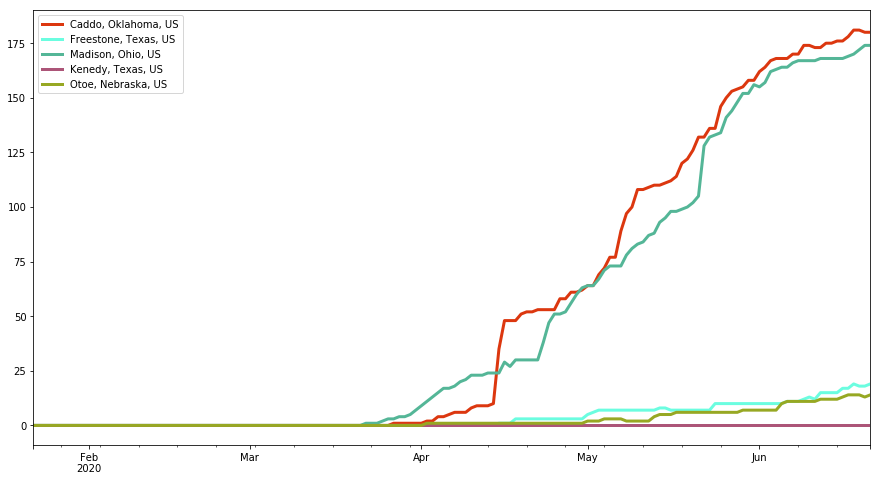

In [59]:
#lets plot 5 ramdom cityes
plotRandomCities(covid_df,5)

Selected cities:  ['Benton, Tennessee, US', 'Mercer, West Virginia, US', 'Dearborn, Indiana, US', 'Chilton, Alabama, US', 'Grant, West Virginia, US', 'Lowndes, Alabama, US', 'Frederick, Virginia, US', 'Sarasota, Florida, US', 'Howard, Texas, US', 'Burnet, Texas, US', 'Greene, Virginia, US', 'Sussex, New Jersey, US', 'Hanover, Virginia, US', 'Marshall, Illinois, US', 'Okmulgee, Oklahoma, US']
Getting Data for city:  Benton, Tennessee, US
Getting Data for city:  Mercer, West Virginia, US
Getting Data for city:  Dearborn, Indiana, US
Getting Data for city:  Chilton, Alabama, US
Getting Data for city:  Grant, West Virginia, US
Getting Data for city:  Lowndes, Alabama, US
Getting Data for city:  Frederick, Virginia, US
Getting Data for city:  Sarasota, Florida, US
Getting Data for city:  Howard, Texas, US
Getting Data for city:  Burnet, Texas, US
Getting Data for city:  Greene, Virginia, US
Getting Data for city:  Sussex, New Jersey, US
Getting Data for city:  Hanover, Virginia, US
Getting 

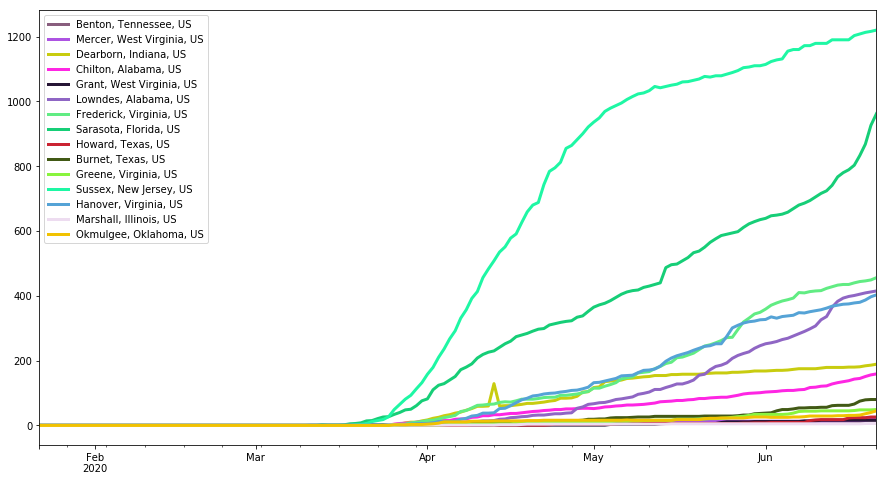

In [60]:
#lets plot 15 cityes
plotRandomCities(covid_df, 15)

Selected cities:  ['San Patricio, Texas, US', 'Morris, Texas, US', 'Lake, Colorado, US', 'Hillsborough, New Hampshire, US', 'Berrien, Michigan, US', 'Coke, Texas, US', 'Carroll, Kentucky, US', 'Porter, Indiana, US', 'Shelby, Missouri, US', 'Out of CA, California, US', 'Hartford, Connecticut, US', 'Polk, Florida, US', 'Nelson, North Dakota, US', 'Northampton, Virginia, US', 'Chase, Nebraska, US']
Getting Data for city:  San Patricio, Texas, US
Getting Data for city:  Morris, Texas, US
Getting Data for city:  Lake, Colorado, US
Getting Data for city:  Hillsborough, New Hampshire, US
Getting Data for city:  Berrien, Michigan, US
Getting Data for city:  Coke, Texas, US
Getting Data for city:  Carroll, Kentucky, US
Getting Data for city:  Porter, Indiana, US
Getting Data for city:  Shelby, Missouri, US
Getting Data for city:  Out of CA, California, US
Getting Data for city:  Hartford, Connecticut, US
Getting Data for city:  Polk, Florida, US
Getting Data for city:  Nelson, North Dakota, US


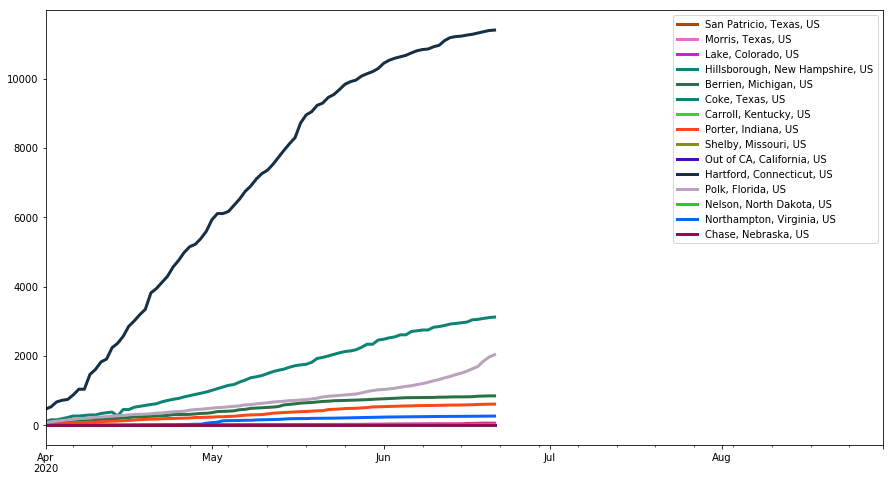

In [61]:
#lets start form Apt 1

plotRandomCities(covid_df, 15,'2020-04-01')

Selected cities:  ['Deer Lodge, Montana, US', 'Todd, Kentucky, US', 'Belknap, New Hampshire, US', 'Radford, Virginia, US', 'Newport, Rhode Island, US', 'Coosa, Alabama, US', 'Casey, Kentucky, US', 'Atlantic, New Jersey, US', 'Shelby, Missouri, US', 'Clarendon, South Carolina, US', 'Ste. Genevieve, Missouri, US', 'Arapahoe, Colorado, US', 'Buena Vista, Iowa, US', 'Waller, Texas, US', 'St. Landry, Louisiana, US']
Getting Data for city:  Deer Lodge, Montana, US
Getting Data for city:  Todd, Kentucky, US
Getting Data for city:  Belknap, New Hampshire, US
Getting Data for city:  Radford, Virginia, US
Getting Data for city:  Newport, Rhode Island, US
Getting Data for city:  Coosa, Alabama, US
Getting Data for city:  Casey, Kentucky, US
Getting Data for city:  Atlantic, New Jersey, US
Getting Data for city:  Shelby, Missouri, US
Getting Data for city:  Clarendon, South Carolina, US
Getting Data for city:  Ste. Genevieve, Missouri, US
Getting Data for city:  Arapahoe, Colorado, US
Getting Data

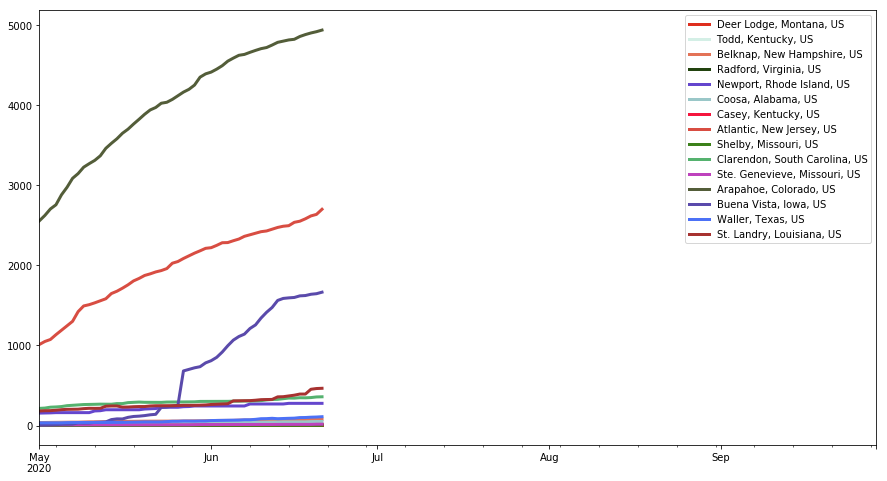

In [62]:
#lets try may 1st
plotRandomCities(covid_df, 15,'2020-05-01')

-----------

## I have a promble 

When looking at the data the dataset only have data for the last 151 days and I can see that out of which starting Apr 1, 2020 is somthing
good we can use. 

I can not use DeepAR on this data because DeepAR needs at least 300 observations available across all training time series and we have at most 151.

>We recommend training a DeepAR model on as many time series as are available. Although a DeepAR model trained on a single time series might work well, standard forecasting algorithms, such as ARIMA or ETS, might provide more accurate results. The DeepAR algorithm starts to outperform the standard methods when your dataset contains hundreds of related time series. Currently, DeepAR requires that the total number of observations available across all training time series is at least 300.
Source: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html

## Good News:
Maybe I can use other `Time Series Forecasting Model(TSFMs)`


## Researching models (TSFMs)

***AR (autoregressive model):***
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
The notation for the model involves specifying the order of the model p as a parameter to the AR function, e.g. AR(p). For example, AR(1) is a first-order autoregression model.
The method is suitable for univariate time series without trend and seasonal components.[^1]

***MA (moving-average model):***
The moving average (MA) method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.
A moving average model is different from calculating the moving average of the time series.
The notation for the model involves specifying the order of the model q as a parameter to the MA function, e.g. MA(q). For example, MA(1) is a first-order moving average model.
The method is suitable for univariate time series without trend and seasonal components.[^1]

***ARMA (autoregressive-moving-average model):***
The Autoregressive Moving Average (ARMA) method models the next step in the sequence as a linear function of the observations and resiudal errors at prior time steps.
It combines both Autoregression (AR) and Moving Average (MA) models.
The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to an ARMA function, e.g. ARMA(p, q). An ARIMA model can be used to develop AR or MA models.
The method is suitable for univariate time series without trend and seasonal components.[^1]

***ARIMA (autoregressive integrated moving average model):***
The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps.
It combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I).
The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function, e.g. ARIMA(p, d, q). An ARIMA model can also be used to develop AR, MA, and ARMA models.
The method is suitable for univariate time series with trend and without seasonal components.[^1]

***SARIMA (seasonal autoregressive integrated moving average model):***
The  [Seasonal Autoregressive Integrated Moving Average (SARIMA)](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)  method models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.
It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.
The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function and AR(P), I(D), MA(Q) and m parameters at the seasonal level, e.g. SARIMA(p, d, q)(P, D, Q)m where “m” is the number of time steps in each season (the seasonal period). A SARIMA model can be used to develop AR, MA, ARMA and ARIMA models.
The method is suitable for univariate time series with trend and/or seasonal components.[^1]

***SARIMAX (seasonal autoregressive integrated moving average model with exogenous variables):***
The Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors ([SARIMAX](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)) is an extension of the SARIMA model that also includes the modeling of exogenous variables.
Exogenous variables are also called covariates and can be thought of as parallel input sequences that have observations at the same time steps as the original series. The primary series may be referred to as endogenous data to contrast it from the exogenous sequence(s). The observations for exogenous variables are included in the model directly at each time step and are not modeled in the same way as the primary endogenous sequence (e.g. as an AR, MA, etc. process).
The SARIMAX method can also be used to model the subsumed models with exogenous variables, such as ARX, MAX, ARMAX, and ARIMAX.
The method is suitable for univariate time series with trend and/or seasonal components and exogenous variables.[^1]

***VARMA (vector autoregressive moving average model):***
The Vector Autoregression Moving-Average (VARMA) method models the next step in each time series using an ARMA model. It is the generalization of ARMA to multiple parallel time series, e.g. multivariate time series.
The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to a VARMA function, e.g. VARMA(p, q). A VARMA model can also be used to develop VAR or VMA models.
The method is suitable for multivariate time series without trend and seasonal components.[^1]

-----

***Vector Autoregression (VAR)***
The Vector Autoregression (VAR) method models the next step in each time series using an AR model. It is the generalization of AR to multiple parallel time series, e.g. multivariate time series.
The notation for the model involves specifying the order for the AR(p) model as parameters to a VAR function, e.g. VAR(p).
The method is suitable for multivariate time series without trend and seasonal components.[^1]

***Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)***
The Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX) is an extension of the VARMA model that also includes the modeling of exogenous variables. It is a multivariate version of the ARMAX method.
Exogenous variables are also called covariates and can be thought of as parallel input sequences that have observations at the same time steps as the original series. The primary series(es) are referred to as endogenous data to contrast it from the exogenous sequence(s). The observations for exogenous variables are included in the model directly at each time step and are not modeled in the same way as the primary endogenous sequence (e.g. as an AR, MA, etc. process).
The VARMAX method can also be used to model the subsumed models with exogenous variables, such as VARX and VMAX.
The method is suitable for multivariate time series without trend and seasonal components with exogenous variables.[^1]

***Simple Exponential Smoothing (SES)***
The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps.
The method is suitable for univariate time series without trend and seasonal components.[^1]


***Holt Winter’s Exponential Smoothing (HWES)***

The  [Holt Winter’s Exponential Smoothing](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/)  (HWES) also called the Triple Exponential Smoothing method models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account.
The method is suitable for univariate time series with trend and/or seasonal components.[^1]

***ARCH (autoregressive conditional heteroscedasticity model)***
Autoregressive conditional heteroskedasticity (ARCH) is a time-series statistical model used to analyze effects left unexplained by econometric models. In these models, the error term is the residual result left unexplained by the model. The assumption of econometric models is that the [variance](https://www.investopedia.com/terms/v/variance.asp) of this term will be uniform. This is known as "homoskedasticity." However, in some circumstances, this variance is not uniform, but "heteroskedastic."[^2]
***ARIMAX (autoregressive integrated moving average model with exogenous variables)***
A time series model using the Autoregressive Integrated Moving Average with exogenous variables (ARIMAX) function was developed to predict impacts from groundwater pumping on Silver Springs discharge in Ocala Florida. This effort was conducted to determine the effects of groundwater withdrawal using the statistical relationship between rainfall and spring discharge at Silver Springs. Other statistical models were developed in previous work by both Southwest Florida Water Management Districts and St Johns River Water Management District. However, there were several opportunities for improvement including using consistent data, model calibration period, and residual periods. Additionally previous statistical methods included Multiple Linear Regression and Line of Organic Correlation methods. These methods did not account for autocorrelation that present in many time series analysis. Through inter-district collaboration, data was made consistent and new methods were explored. The ARIMAX model was explored in this paper and is useful for prediction when autoregressive patterns are present in model residuals that bias modeled coefficients.[^3]
***GARCH (generalized autoregressive conditional heteroscedasticity model)***
A natural generalization of the ARCH (Autoregressive Conditional Heteroskedastic) process introduced in Engle (1982) to allow for past conditional variances in the current conditional variance equation is proposed. Stationarity conditions and autocorrelation structure for this new class of parametric models are derived. Maximum likelihood estimation and testing are also considered.[^4] 

***SARIA (seasonal autoregressive moving average model)***


----
*****Source:*****

[^1]:[11 Classical Time Series Forecasting Methods in Python (Cheat Sheet)](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

[^2]:[Autoregressive Conditional Heteroskedasticity (ARCH)](https://www.investopedia.com/terms/a/autoregressive-conditional-heteroskedasticity.asp)

[^3]:[Autoregressive Integrated Moving Average Model with exogenous variables (ARIMAX) transfer function model for Sharpes Ferry Well and Silver Springs](https://rstudio-pubs-static.s3.amazonaws.com/180268_8acc87dd9fa2435c8a8e5ed6b815be2c.html)

[^4]:[Generalized autoregressive conditional heteroskedasticity](https://www.sciencedirect.com/science/article/abs/pii/0304407686900631?via%3Dihub)